In [ ]:
import yfinance as yf
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
import torch.nn.functional as fn
from torch.nn import Linear
from torch.nn import ReLU
from torch.optim import Adam
from tqdm import tqdm

Get data from yahoo finance

In [ ]:
# Start date and End date
start_date = '2012-01-01'
end_date = '2024-01-01'

America_tickers1 = ['AAPL']
America_data1 = yf.download(America_tickers1, start=start_date, end=end_date)['Adj Close']


America_array1 = np.array(America_data1.dropna())



[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(America_data1[:2500])

Date
2012-01-03     12.433825
2012-01-04     12.500644
2012-01-05     12.639425
2012-01-06     12.771559
2012-01-09     12.751300
                 ...    
2021-12-01    162.701050
2021-12-02    161.703720
2021-12-03    159.807831
2021-12-06    163.244156
2021-12-07    169.030548
Name: Adj Close, Length: 2500, dtype: float64


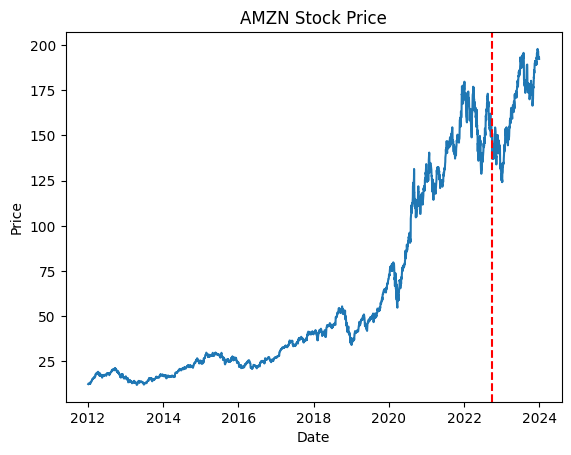

In [ ]:
import pandas as pd
plt.plot(America_data1)
plt.title('AMZN Stock Price')
plt.axvline(x=pd.to_datetime('2022-09-23'), color='r', linestyle='--', label='Vertical Line')

plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Transform the data.

The first row is $t_0$ to $t_{29}$

The second row is $t_1$ to $t_{30}$

The third row is $t_2$ to $t_{31}$....

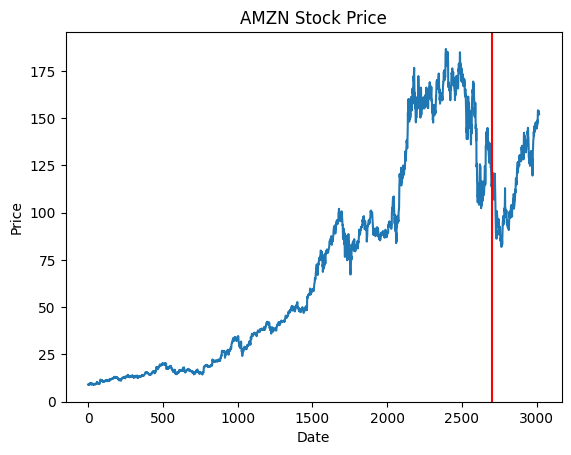

In [ ]:
plt.plot(America_array1)
plt.title('AMZN Stock Price')
plt.axvline(x=2700, color='r', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

(3017,)


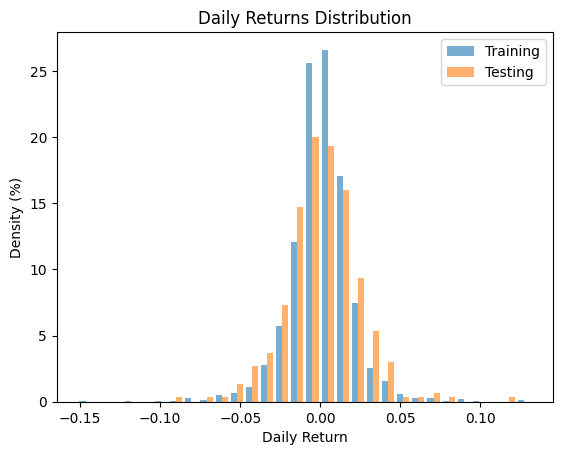

Kolmogorov-Smirnov test: statistic= 0.09336811453530697, p-value= 0.01347943569344626


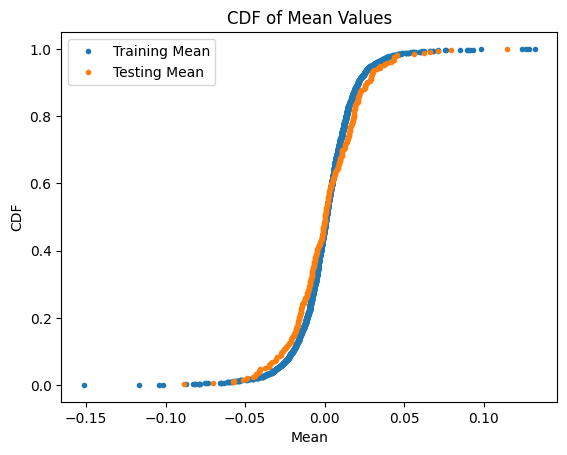

In [ ]:
from scipy import stats


# Count the daily returns
Returns = np.log(America_array1[1:] / America_array1[:-1])

print(Returns.shape)

Training = Returns[100:2700]
Testing = Returns[2700:]

bins = np.histogram(np.hstack((Training, Testing)), bins=30)[1]  # get the bin edges
plt.hist([Training, Testing], bins, density=True, alpha=0.6,
         label=['Training', 'Testing'])

plt.title('Daily Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Density (%)')
plt.legend()
plt.show()


# Kolmogorov-Smirnov Test
ks_stat, ks_p_value = stats.ks_2samp(Training, Testing)
print(f"Kolmogorov-Smirnov test: statistic= {ks_stat}, p-value= {ks_p_value}")

# ECDF Plot
def plot_ecdf(data, label):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, marker='.', linestyle='none', label=label)

plt.figure()
plot_ecdf(Training, 'Training Mean')
plot_ecdf(Testing, 'Testing Mean')
plt.xlabel('Mean')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Mean Values')
plt.show()




Shape of transformed_data:  (2988, 31)


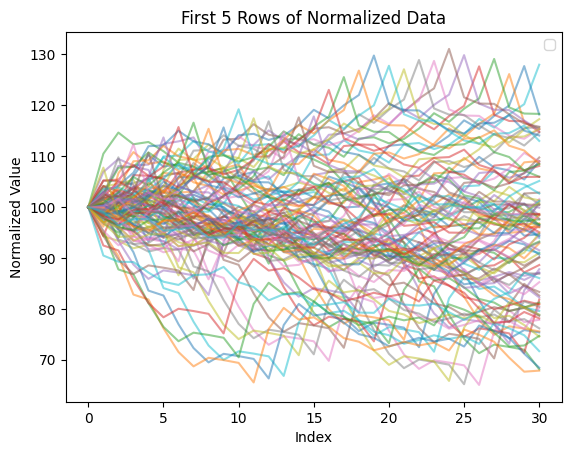

In [ ]:
# Parameters
window_size = 30 + 1
num_windows = len(America_array1) - window_size + 1

# Initialize the new array
transformed_data = np.zeros(( num_windows, window_size))

# Shift the data to make it start with 100
for i in range(num_windows):
    transformed_data[i] = America_array1[i:i + window_size] - America_array1[i] + 100


print("Shape of transformed_data: ",transformed_data.shape)  # Should print (30, 2739)


# Plot the first 100 Path
for i in range(100):
  plt.plot(transformed_data[2700+i],alpha = 0.5)

plt.title('First 5 Rows of Normalized Data')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


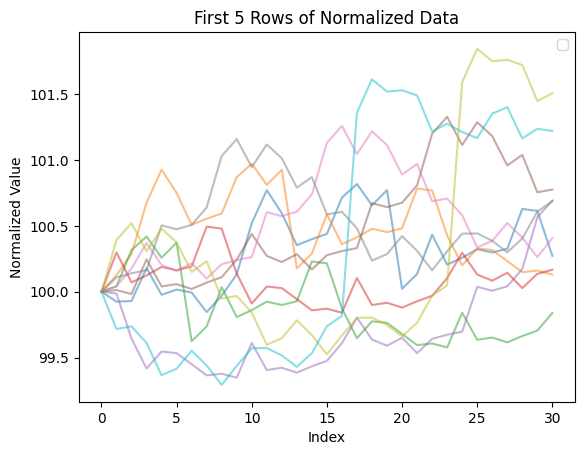

In [ ]:

# Plot the first 100 Path
for i in range(10):
  plt.plot(transformed_data[i*7],alpha = 0.5)

plt.title('First 5 Rows of Normalized Data')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [ ]:
# Split the data
# The first 2500 for training, the rest for testing

Training_data = torch.from_numpy(transformed_data[100:2700]).float().T
Testing_data = torch.from_numpy(transformed_data[2700:]).float().T
print("Shape of Training data: ",Training_data.shape)
print("Shape of Testing data: ",Testing_data.shape)

Shape of Training data:  torch.Size([31, 2600])
Shape of Testing data:  torch.Size([31, 288])


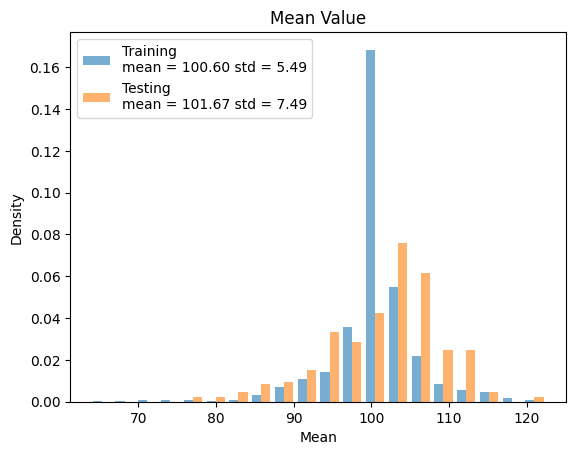

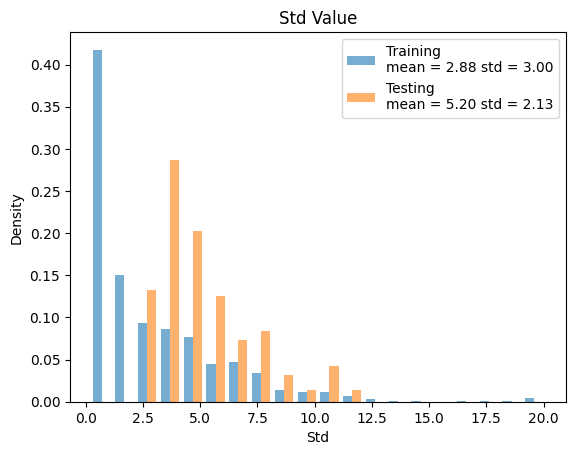

In [ ]:
# Calculate the mean and std of each paths and plot
mean = torch.mean(Training_data, dim=0)
std = torch.std(Training_data, dim=0)



test_mean = torch.mean(Testing_data, dim=0)
test_std = torch.std(Testing_data, dim=0)



bins=np.histogram(np.hstack((mean.cpu().detach().numpy(),test_mean.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([mean.numpy(), test_mean.numpy()], bins, density = True, alpha = 0.6,
         label = [f'Training\nmean = {mean.mean():2.2f} std = {mean.std():2.2f}',
                  f'Testing\nmean = {test_mean.mean():2.2f} std = {test_mean.std():2.2f}'])

plt.title(f"Mean Value")
plt.xlabel("Mean")
plt.ylabel("Density")
plt.legend()
plt.show()

bins=np.histogram(np.hstack((std.cpu().detach().numpy(),test_std.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([std.numpy(), test_std.numpy()], bins, density = True, alpha = 0.6,
         label = [f'Training\nmean = {std.mean():2.2f} std = {std.std():2.2f}',
                  f'Testing\nmean = {test_std.mean():2.2f} std = {test_std.std():2.2f}'])

plt.title(f"Std Value")
plt.xlabel("Std")
plt.ylabel("Density")
plt.legend()
plt.show()


Kolmogorov-Smirnov test: statistic=0.29455128205128206, p-value=2.1196376182486253e-20
Kolmogorov-Smirnov test: statistic=0.5976709401709401, p-value=3.9776788609908056e-88


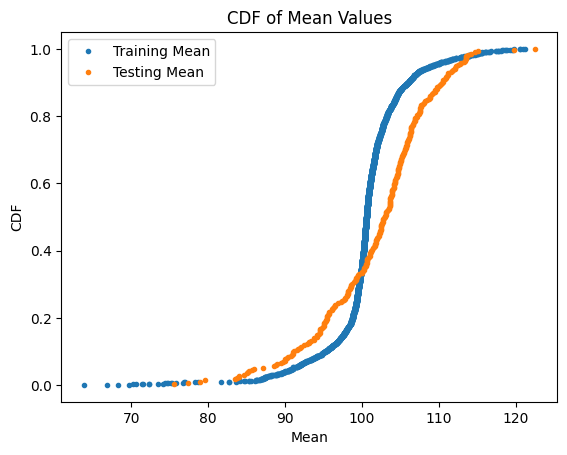

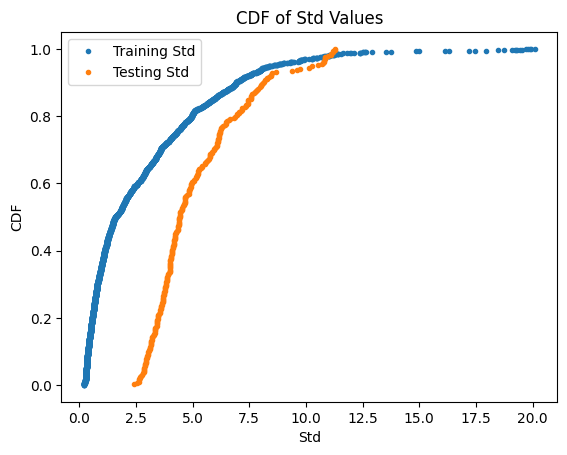

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Convert to numpy arrays
mean_train_np = mean.numpy()
std_train_np = std.numpy()
mean_test_np = test_mean.numpy()
std_test_np = test_std.numpy()

# Kolmogorov-Smirnov Test
ks_stat, ks_p_value = stats.ks_2samp(mean_train_np, mean_test_np)
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p_value}")

ks_stat, ks_p_value = stats.ks_2samp(std_train_np, std_test_np)
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p_value}")


# ECDF Plot
def plot_ecdf(data, label):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, marker='.', linestyle='none', label=label)

plt.figure()
plot_ecdf(mean_train_np, 'Training Mean')
plot_ecdf(mean_test_np, 'Testing Mean')
plt.xlabel('Mean')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Mean Values')
plt.show()

plt.figure()
plot_ecdf(std_train_np, 'Training Std')
plot_ecdf(std_test_np, 'Testing Std')
plt.xlabel('Std')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Std Values')
plt.show()

Calculate the std for the testing data

In [ ]:
std_Windows = 100
std_num_windows = 2738 - std_Windows

print(std_num_windows)
# Initialize the new array
std_data = np.zeros(( std_num_windows))


# Shift the data to make it start with 100
for i in range(std_num_windows):
    data_prev = America_array1[i:i+100] - America_array1[i] + 100
    data_next = America_array1[i+1:i+101] - America_array1[i] + 100
    temp = np.log(data_next / 100)
    std_data[i] = np.std(temp)

    # data_return = np.log((data_prev - 100)/100)

    # std_data[i] = np.std(data_prev)


training_std_data = torch.from_numpy(std_data[:2400]).float()
training_std_data = training_std_data.reshape(-1,1)

testing_std_data = torch.from_numpy(std_data[2400:]).float()
testing_std_data = testing_std_data.reshape(-1,1)




print(training_std_data.shape)
print(testing_std_data.shape)
print(testing_std_data[:10])


2638
torch.Size([2400, 1])
torch.Size([238, 1])
tensor([[0.0653],
        [0.0657],
        [0.0656],
        [0.0664],
        [0.0658],
        [0.0657],
        [0.0619],
        [0.0608],
        [0.0589],
        [0.0511]])


In [ ]:
## Deep Hedging

std_Windows = 100
std_num_windows = 2738 - std_Windows

print(std_num_windows)
# Initialize the new array
deep_std_data = np.zeros(( std_num_windows))


# Shift the data to make it start with 100
for i in range(std_num_windows):
    data_prev = America_array1[i:i+100] - America_array1[i] + 100

    std_data[i] = np.std(data_prev)


deep_training_std_data = torch.from_numpy(deep_std_data[:2400]).float()
deep_training_std_data = deep_training_std_data.reshape(-1,1)

deep_testing_std_data = torch.from_numpy(deep_std_data[2400:]).float()
deep_testing_std_data = deep_testing_std_data.reshape(-1,1)

2638



BS Delta Hedging

torch.Size([238])
torch.Size([238])


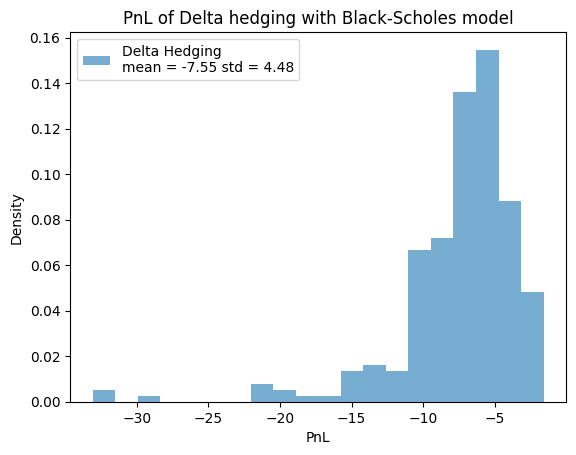

Mean:  -7.547637
Std:  4.469392


In [ ]:
# Strike price K = 100
#Hedging via formula

T = 30/252
dt = 1/252
s0 = 100


def european_option_payoff(prices: torch.Tensor, strike=100):
    return fn.relu(prices[-1, :] - strike)

def european_option_delta(log_moneyness, time_expiry, volatility) :
    s, t, v =  log_moneyness, time_expiry, volatility
    normal = Normal(torch.tensor(0.0), torch.tensor(1.0))
    return normal.cdf((s + (v ** 2 / 2) * t) / (v * torch.sqrt(t)))
def BS_compute_modelhedge_pnl( T, dt, sigma, paths, payoff, cost) :

    Paths = paths

    hedge = torch.zeros_like(Paths[:1]).reshape(-1)
    pnl = 0
    hedge_weight = torch.zeros_like(Paths)

    x_log_moneyness = torch.full_like(Paths[0, :], s0/100).log()

    x_sigma = sigma
    print(x_sigma.shape)

    for n in range(Paths.shape[0] - 1):
        x_time_expiry = torch.full_like(x_log_moneyness, T - n * dt)
        prev_hedge = hedge

        # print(torch.log(Paths[n,:]/100).shape)
        # print(x_time_expiry.shape)
        # print(x_sigma[:].shape)
        # print("--------")

        hedge = european_option_delta(torch.log(Paths[n,:]/100), x_time_expiry[:], x_sigma[:])

        hedge_weight[n] = hedge
        pnl += (hedge) * (Paths[n + 1] - Paths[n])

        pnl -= cost * torch.abs(hedge - prev_hedge) * Paths[n]

    pnl -= payoff(Paths)
    return pnl , hedge_weight


AAPL_with_nocost, hedge_weight_AAPL_with_nocost = BS_compute_modelhedge_pnl(T=T, dt=dt, sigma=testing_std_data.reshape(-1), paths=Testing_data, payoff=european_option_payoff, cost=0.0)
print(AAPL_with_nocost.shape)

plt.hist(AAPL_with_nocost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Delta Hedging\nmean = {AAPL_with_nocost.mean():2.2f} std = {AAPL_with_nocost.std():2.2f}')
plt.title(f"PnL of Delta hedging with Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean: ", np.mean(AAPL_with_nocost.cpu().detach().numpy()))
print("Std: ", np.std(AAPL_with_nocost.cpu().detach().numpy()))

torch.Size([238])
torch.Size([238])


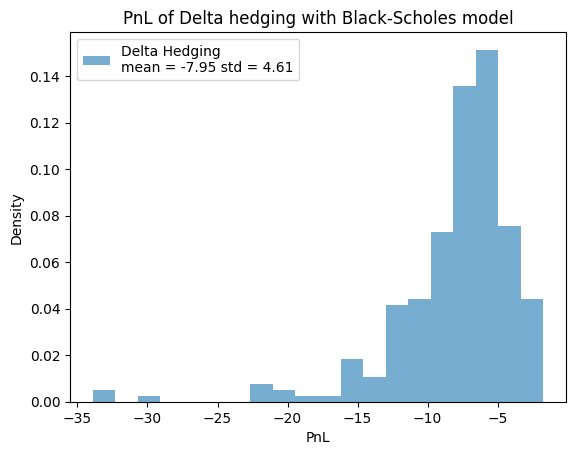

In [ ]:
AAPL_with_Tcost, hedge_weight_AAPL_with_Tcost= BS_compute_modelhedge_pnl(T=T, dt=dt, sigma=testing_std_data.reshape(-1), paths=Testing_data, payoff=european_option_payoff, cost=0.001425)
print(AAPL_with_Tcost.shape)

plt.hist(AAPL_with_Tcost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Delta Hedging\nmean = {AAPL_with_Tcost.mean():2.2f} std = {AAPL_with_Tcost.std():2.2f}')
plt.title(f"PnL of Delta hedging with Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()

torch.Size([238])
torch.Size([238])


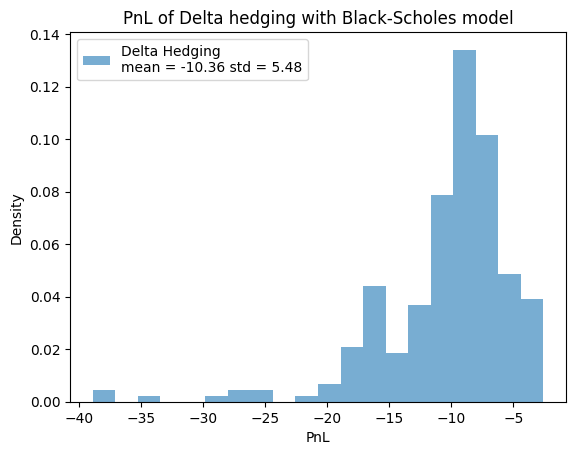

In [ ]:
AAPL_with_Americacost, hedge_weight_AAPL_with_Americacost = BS_compute_modelhedge_pnl(T=T, dt=dt, sigma=testing_std_data.reshape(-1), paths=Testing_data, payoff=european_option_payoff, cost=0.01)
print(AAPL_with_Americacost.shape)

plt.hist(AAPL_with_Americacost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Delta Hedging\nmean = {AAPL_with_Americacost.mean():2.2f} std = {AAPL_with_Americacost.std():2.2f}')
plt.title(f"PnL of Delta hedging with Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()

#### Compare

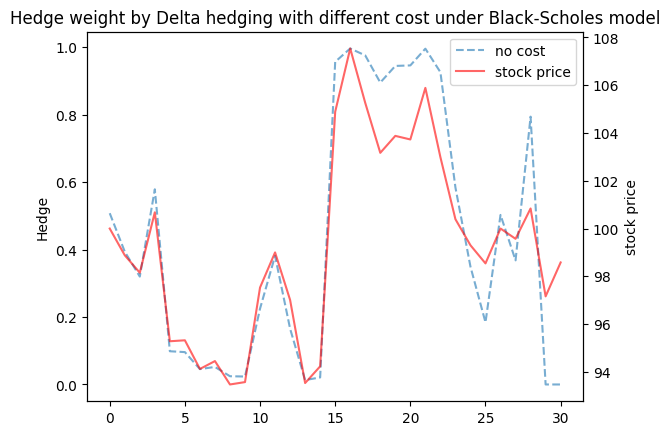

In [ ]:
data = hedge_weight_AAPL_with_Americacost.cpu().detach().numpy().T
PATH = 200

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "no cost", linestyle = '--')
lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')
lns = lns1+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.title(f'Hedge weight by Delta hedging with different cost under Black-Scholes model')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()
# print(data[PATH])
# print(Testing_data[:,PATH])

In [ ]:
print(data[PATH])
print(Testing_data[:,PATH])

[5.0795484e-01 8.0046928e-01 7.8595459e-01 8.7567079e-01 7.4680483e-01
 6.3968462e-01 7.2121727e-01 7.9958344e-01 8.6568677e-01 7.7683753e-01
 9.3913627e-01 9.6174026e-01 9.4086796e-01 7.3741877e-01 5.7067841e-01
 6.9776177e-04 2.2649765e-06 6.6757202e-06 8.9406967e-08 0.0000000e+00
 0.0000000e+00 5.9604645e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
tensor([100.0000, 103.2826, 103.0239, 104.3867, 102.4271, 101.2434, 102.0491,
        102.9145, 103.7899, 102.5166, 105.1128, 105.7296, 104.8940, 101.8800,
        100.4775,  91.3459,  88.2226,  89.1675,  87.5660,  87.3472,  87.4070,
         89.0704,  87.0683,  86.1918,  83.6319,  84.1200,  85.4646,  86.8492,
         90.7238,  86.0025,  88.2237])


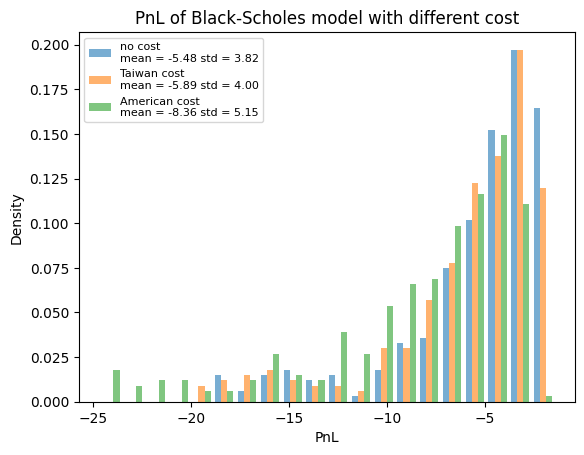

In [ ]:
bins=np.histogram(np.hstack((AAPL_with_nocost.cpu().detach().numpy(),
                             AAPL_with_Tcost.cpu().detach().numpy(),
                             AAPL_with_Americacost.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_with_nocost.cpu().detach().numpy(),
          AAPL_with_Tcost.cpu().detach().numpy() ,
          AAPL_with_Americacost.cpu().detach().numpy()], bins, density = True, alpha = 0.6,

         label = [f'no cost\nmean = {AAPL_with_nocost.mean():2.2f} std = {AAPL_with_nocost.std():2.2f}',
                  f'Taiwan cost\nmean = {AAPL_with_Tcost.mean():2.2f} std = {AAPL_with_Tcost.std():2.2f}',
                  f'American cost\nmean = {AAPL_with_Americacost.mean():2.2f} std = {AAPL_with_Americacost.std():2.2f}'])

plt.title(f"PnL of Black-Scholes model with different cost")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()


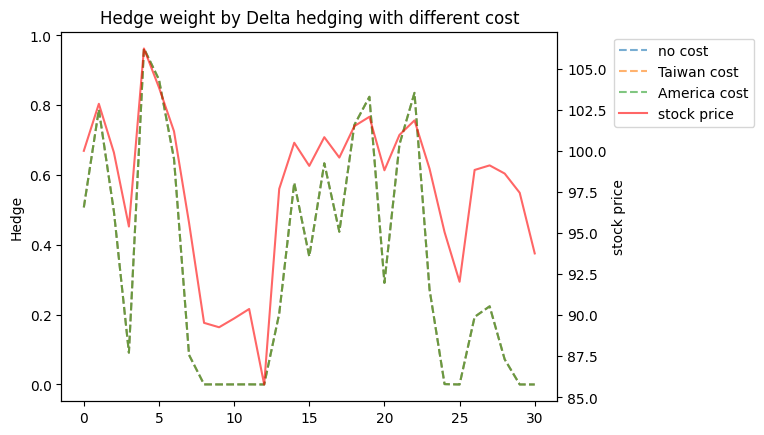

In [ ]:
data = hedge_weight_AAPL_with_nocost.cpu().detach().numpy().T
data1 = hedge_weight_AAPL_with_Tcost.cpu().detach().numpy().T
data2 = hedge_weight_AAPL_with_Americacost.cpu().detach().numpy().T

PATH = 20

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "no cost", linestyle = '--')
lns2 = ax1.plot(data1[PATH], alpha = 0.6, label = "Taiwan cost", linestyle = '--')
lns3 = ax1.plot(data2[PATH], alpha = 0.6, label = "America cost", linestyle = '--')

lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left', bbox_to_anchor=(1.1, 1))
plt.title(f'Hedge weight by Delta hedging with different cost')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()

In [ ]:
# data = hedge_weight_AAPL_with_Americacost.cpu().detach().numpy().T
# for i in range(10):
#   plt.plot(data[i*7,:], alpha = 0.6)
# plt.title(f'{50} Paths generated by Black-Scholes model')
# plt.xlabel('Time steps')
# plt.ylabel('Price')
# plt.show()

## Deep Hedging


#### Setup

In [ ]:
def entropic_loss(pnl, lambda_val = 1) -> torch.Tensor:
    return torch.mean( torch.exp(-lambda_val * pnl))/lambda_val
def VaR_loss(x, alpha):
    x_sorted, _ = torch.sort(x)
    tail_index = int((1 - alpha) * len(x))
    return x_sorted[tail_index]

def CVaR_loss(x, alpha):
    CVaR_value = -torch.mean(x[x < VaR_loss(x, alpha)])/100

    return CVaR_value

In [ ]:

def compute_profit_and_loss(
    hedging_model: torch.nn.Module,
    isBS, # bs or heston string
    T ,
    dt,
    sigma,
    paths,
    cost,
    payoff
) -> torch.Tensor:

    Paths = paths
    # Change here to connect signature GAN


    # hedge_weight = torch.zeros_like(Paths)
    hedge = torch.zeros_like(Paths[:1]).reshape(-1)
    pnl = 0
    hedge_weight = torch.zeros_like(Paths)

    hedge = torch.zeros_like(Paths[:1]).reshape(-1)
    vol_model = torch.zeros_like(Paths[:1]).reshape(-1)
    pnl = 0

    for n in range(Paths.shape[0] - 1):
        log_S = (Paths[n, :, None] / s0).log()
        M = torch.full_like(log_S, T - n * dt)

        # Model's inputs
        if isBS:
            # x_sigma = torch.full_like(log_S, sigma)
            # print(x_sigma.shape)
            x_sigma = sigma
            x = torch.cat([log_S, M, x_sigma], 1)
            prev_hedge = hedge
            hedge = hedging_model(x, prev_hedge)

        else :
            x = torch.cat([log_S, M], 1)
            prev_hedge  = hedge , vol_model
            hedge, vol_model  = hedging_model(x, prev_hedge)

        hedge_weight[n] = hedge


        pnl += hedge * (Paths[n + 1] - Paths[n])

        # Transaction cost
        if isBS:
            pnl -= cost * torch.abs(hedge - prev_hedge) * Paths[n]
        else :
            pnl -= cost * torch.abs(hedge - prev_hedge[0]) * Paths[n]
    # Pay to customers
    pnl -= payoff(Paths)

    return pnl, hedge_weight
def Train( hedging_model: torch.nn.Module,isBS, n_epochs, paths, cost, payoff, loss_type = 'cvar' , parameter = 0.95):
  optim = Adam(hedging_model.parameters(),lr = 0.003)

  loss_history = []
  progress = tqdm(range(n_epochs))

  for _ in progress:
    optim.zero_grad()
    pnl, _ = compute_profit_and_loss(hedging_model,isBS, T, dt, training_std_data.to(DEVICE), paths, cost, payoff)
    if loss_type == 'cvar':
        loss = CVaR_loss(pnl, parameter)
    else:
        loss = entropic_loss(pnl, parameter)
    loss.backward()
    optim.step()

    progress.desc = f"Loss={loss:.5f}"
    loss_history.append(loss.item())

  return loss_history

In [ ]:
#Implement deep hedging algorithm
class MultiLayerPerceptron(torch.nn.ModuleList):
    def __init__(self, in_features, out_features, n_layers=4, n_units=64):
        super().__init__()
        for n in range(n_layers):
            i = in_features if n == 0 else n_units
            self.append(Linear(i, n_units))
            self.append(ReLU())
        self.append(Linear(n_units, out_features))

    def forward(self, x):
        for layer in self:
            x = layer(x)
        return x

class BSHedingModel(torch.nn.Module):
    def __init__(self, in_features=3):
        super().__init__()

        # A four-layer MLP with 32 hidden neurons in each layer
        self.mlp = MultiLayerPerceptron(in_features + 1, 1)

    def forward(self, x, prev):

        x = torch.cat((x, prev.reshape(-1, 1)), 1)
        x = self.mlp(x).reshape(-1)
        x = torch.tanh(x)
        hedge =  x

        return hedge

#### Nocost

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BSmodel = BSHedingModel().to(DEVICE)

history_ffn = Train(BSmodel, True,  2000, Training_data.to(DEVICE), cost = 0.0, payoff = european_option_payoff, loss_type = 'cvar' )

test_sigma = testing_std_data.to(DEVICE).reshape(-1,1)
AAPL_DeepHedging_pnl_cvar_nocost, AAPL_DeepHedging_hedgeweight_cvar_nocost = compute_profit_and_loss(BSmodel, True, T, dt, test_sigma, Testing_data.to(DEVICE), cost = 0.0, payoff =  european_option_payoff)

Loss=0.05247: 100%|██████████| 2000/2000 [01:59<00:00, 16.69it/s]


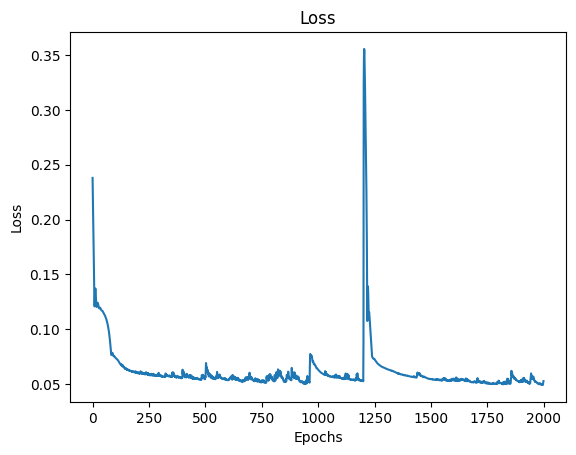

In [ ]:
plt.plot(history_ffn)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

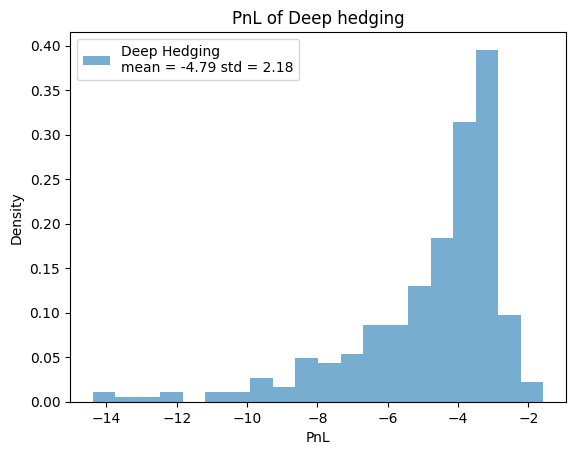

In [ ]:

plt.hist(AAPL_DeepHedging_pnl_cvar_nocost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_cvar_nocost.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar_nocost.std():2.2f}')
plt.title(f"PnL of Deep hedging")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()



In [ ]:
print(AAPL_DeepHedging_hedgeweight_cvar_nocost.shape)

torch.Size([31, 288])


#### T cost

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BSmodel = BSHedingModel().to(DEVICE)

history_ffn = Train(BSmodel, True,  2000, Training_data.to(DEVICE), cost = 0.001425, payoff = european_option_payoff, loss_type = 'cvar' )

test_sigma = testing_std_data.to(DEVICE).reshape(-1,1)
AAPL_DeepHedging_pnl_cvar_Tcost, AAPL_DeepHedging_hedgeweight_cvar_Tcost = compute_profit_and_loss(BSmodel, True, T, dt, test_sigma, Testing_data.to(DEVICE), cost = 0.001425, payoff =  european_option_payoff)

Loss=0.05699: 100%|██████████| 2000/2000 [01:39<00:00, 20.15it/s]


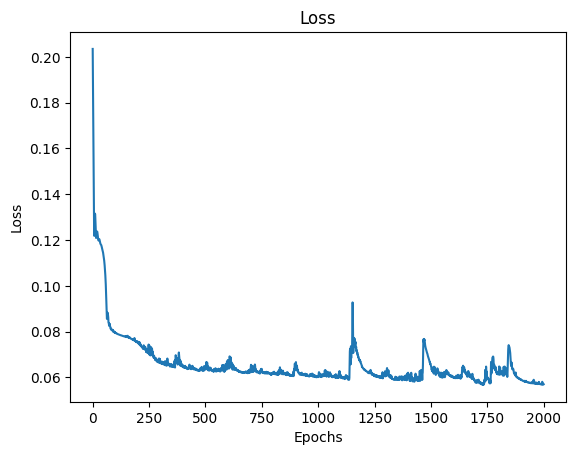

In [ ]:
plt.plot(history_ffn)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

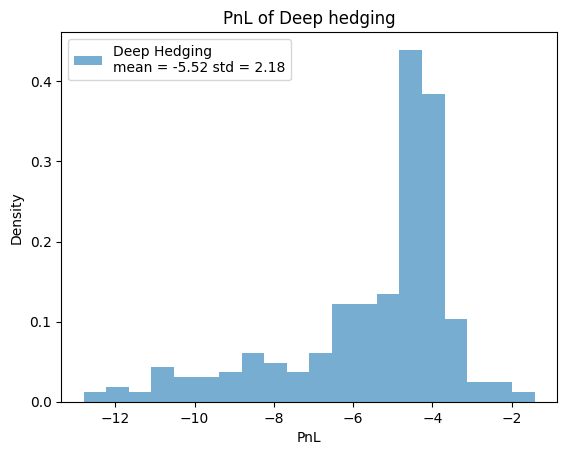

In [ ]:

plt.hist(AAPL_DeepHedging_pnl_cvar_Tcost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_cvar_Tcost.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar_Tcost.std():2.2f}')
plt.title(f"PnL of Deep hedging")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()



#### America cost

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BSmodel = BSHedingModel().to(DEVICE)

history_ffn = Train(BSmodel, True,  2000, Training_data.to(DEVICE), cost = 0.01, payoff = european_option_payoff, loss_type = 'cvar' )

test_sigma = testing_std_data.to(DEVICE).reshape(-1,1)
AAPL_DeepHedging_pnl_cvar, AAPL_DeepHedging_hedgeweight_cvar = compute_profit_and_loss(BSmodel, True, T, dt, test_sigma, Testing_data.to(DEVICE), cost = 0.01, payoff =  european_option_payoff)

Loss=0.07758: 100%|██████████| 2000/2000 [01:39<00:00, 20.12it/s]


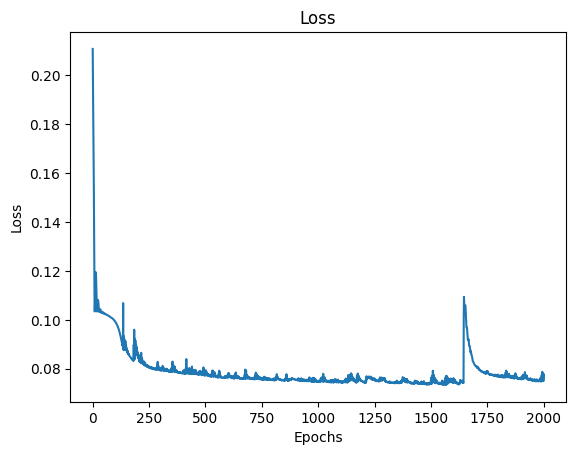

In [ ]:
plt.plot(history_ffn)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

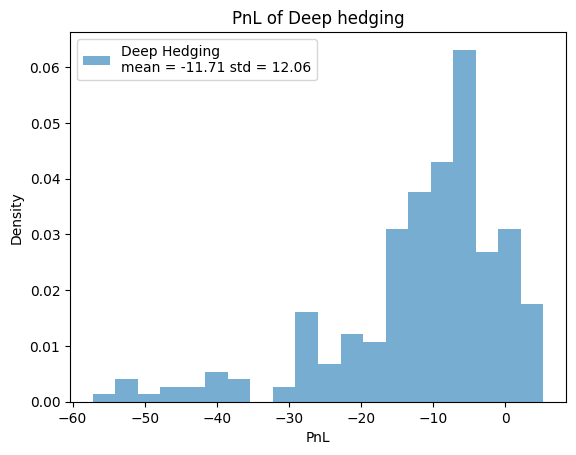

Mean:  -11.709022
Std:  12.033303


In [ ]:

plt.hist(AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_cvar.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar.std():2.2f}')
plt.title(f"PnL of Deep hedging")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()


print("Mean: ", np.mean(AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy()))
print("Std: ", np.std(AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy()))

### Compare

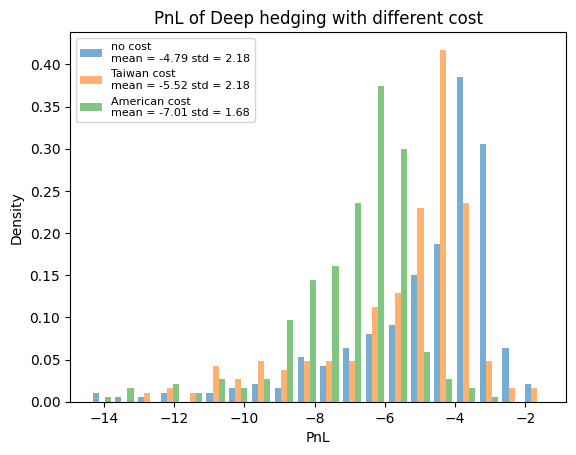

In [ ]:
bins=np.histogram(np.hstack((AAPL_DeepHedging_pnl_cvar_nocost.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_cvar_Tcost.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_DeepHedging_pnl_cvar_nocost.cpu().detach().numpy(),
          AAPL_DeepHedging_pnl_cvar_Tcost.cpu().detach().numpy() ,
          AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy()], bins, density = True, alpha = 0.6,

         label = [f'no cost\nmean = {AAPL_DeepHedging_pnl_cvar_nocost.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar_nocost.std():2.2f}',
                  f'Taiwan cost\nmean = {AAPL_DeepHedging_pnl_cvar_Tcost.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar_Tcost.std():2.2f}',
                  f'American cost\nmean = {AAPL_DeepHedging_pnl_cvar.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar.std():2.2f}'])

plt.title(f"PnL of Deep hedging with different cost")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()



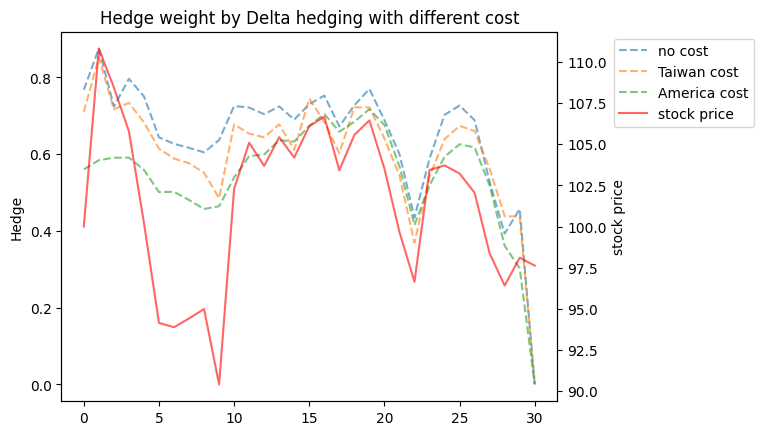

In [ ]:
data = AAPL_DeepHedging_hedgeweight_cvar_nocost.cpu().detach().numpy().T
data1 = AAPL_DeepHedging_hedgeweight_cvar_Tcost.cpu().detach().numpy().T
data2 = AAPL_DeepHedging_hedgeweight_cvar.cpu().detach().numpy().T

PATH = 23

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "no cost", linestyle = '--')
lns2 = ax1.plot(data1[PATH], alpha = 0.6, label = "Taiwan cost", linestyle = '--')
lns3 = ax1.plot(data2[PATH], alpha = 0.6, label = "America cost", linestyle = '--')

lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left', bbox_to_anchor=(1.1, 1))
plt.title(f'Hedge weight by Delta hedging with different cost')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()

### Entropic

#### No cost

In [ ]:

history_ffn = Train(BSmodel, True,  1000, Training_data.to(DEVICE), cost = 0.0, payoff = european_option_payoff, loss_type = 'entropic' )

test_sigma = testing_std_data.to(DEVICE).reshape(-1,1)
AAPL_DeepHedging_pnl_entropic_nocost, AAPL_DeepHedging_hedgeweight_entropic_nocost = compute_profit_and_loss(BSmodel, True, T, dt, test_sigma, Testing_data.to(DEVICE), cost = 0.0, payoff =  european_option_payoff)

Loss=82.00299: 100%|██████████| 1000/1000 [00:50<00:00, 19.90it/s]


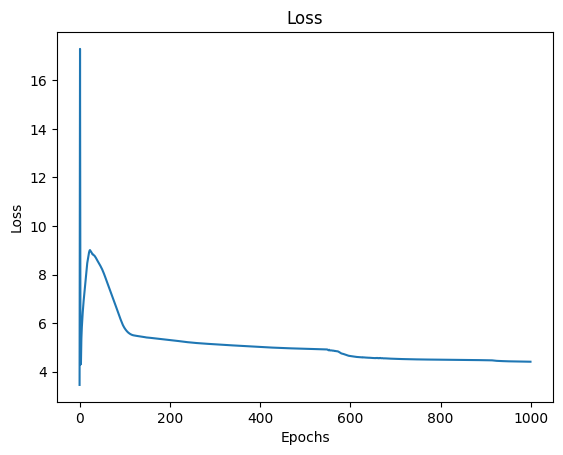

In [ ]:
plt.plot(np.log(np.array(history_ffn)))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

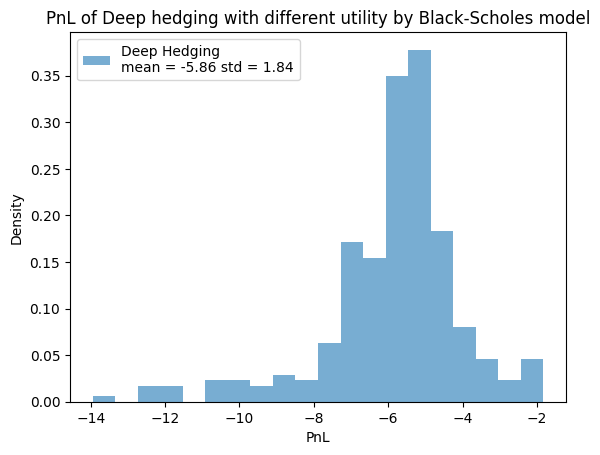

In [ ]:

plt.hist(AAPL_DeepHedging_pnl_entropic_nocost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
        label = f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_entropic_nocost.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic_nocost.std():2.2f}')
plt.title(f"PnL of Deep hedging with different utility by Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()


#### T cost

In [ ]:

history_ffn = Train(BSmodel, True,  1000, Training_data.to(DEVICE), cost = 0.001425, payoff = european_option_payoff, loss_type = 'entropic' )

test_sigma = testing_std_data.to(DEVICE).reshape(-1,1)
AAPL_DeepHedging_pnl_entropic_Tcost , AAPL_DeepHedging_hedgeweight_entropic_Tcost = compute_profit_and_loss(BSmodel, True, T, dt, test_sigma, Testing_data.to(DEVICE), cost = 0.001425, payoff =  european_option_payoff)

Loss=43.63987: 100%|██████████| 1000/1000 [00:50<00:00, 19.77it/s]


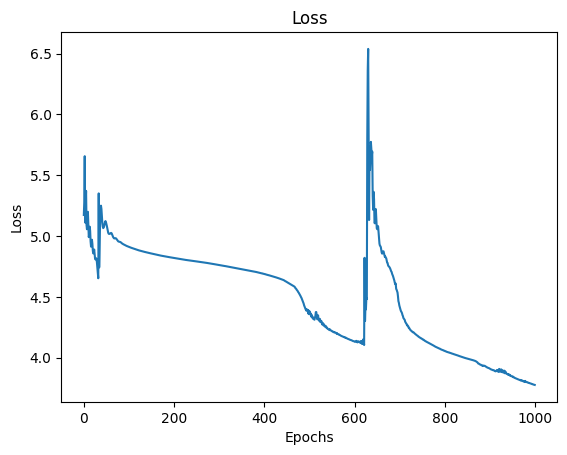

In [ ]:
plt.plot(np.log(np.array(history_ffn)))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

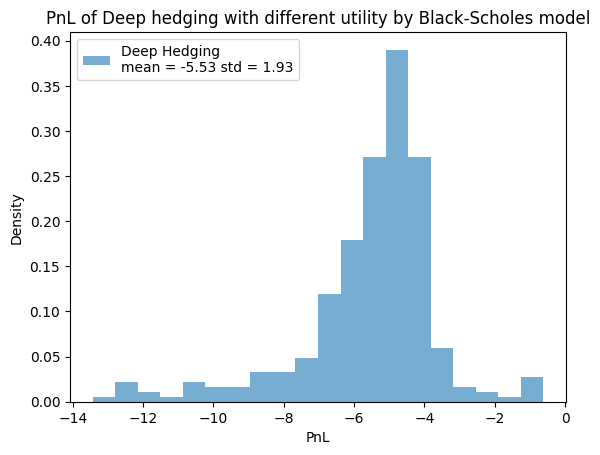

Mean:  -5.529234
Std:  1.9297688


In [ ]:

plt.hist(AAPL_DeepHedging_pnl_entropic_Tcost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
        label = f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_entropic_Tcost.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic_Tcost.std():2.2f}')
plt.title(f"PnL of Deep hedging with different utility by Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean: ", np.mean(AAPL_DeepHedging_pnl_entropic_Tcost.cpu().detach().numpy()))
print("Std: ", np.std(AAPL_DeepHedging_pnl_entropic_Tcost.cpu().detach().numpy()))

#### America cost

In [ ]:

history_ffn = Train(BSmodel, True,  1000, Training_data.to(DEVICE), cost = 0.01, payoff = european_option_payoff, loss_type = 'entropic' )

test_sigma = testing_std_data.to(DEVICE).reshape(-1,1)
AAPL_DeepHedging_pnl_entropic, AAPL_DeepHedging_hedgeweight_entropic = compute_profit_and_loss(BSmodel, True, T, dt, test_sigma, Testing_data.to(DEVICE), cost = 0.01, payoff =  european_option_payoff)

Loss=383.20776: 100%|██████████| 1000/1000 [00:49<00:00, 20.30it/s]


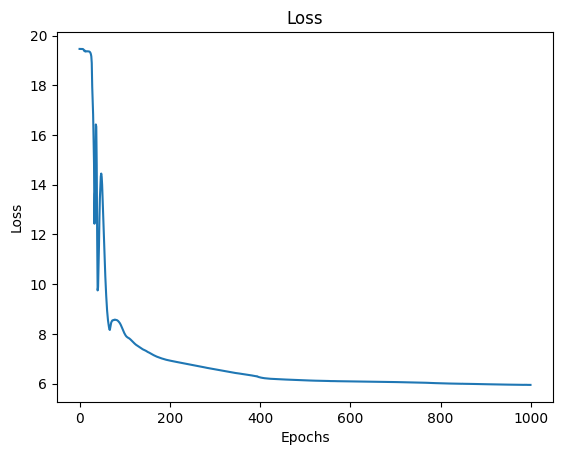

In [ ]:
plt.plot(np.log(np.array(history_ffn)))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

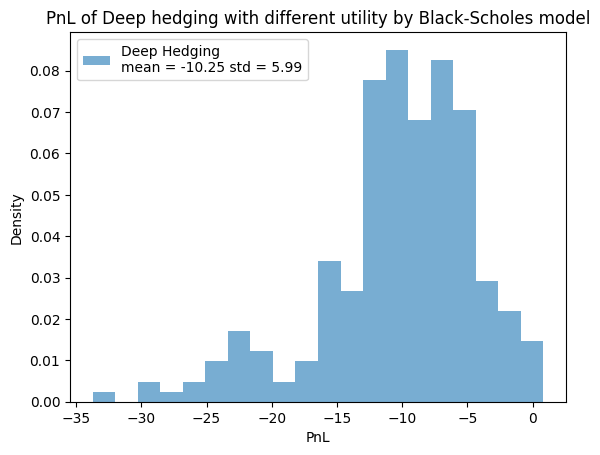

Mean:  -10.2534485
Std:  5.976724


In [ ]:

plt.hist(AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
        label = f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_entropic.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic.std():2.2f}')
plt.title(f"PnL of Deep hedging with different utility by Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean: ", np.mean(AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy()))
print("Std: ", np.std(AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy()))

#### Compare

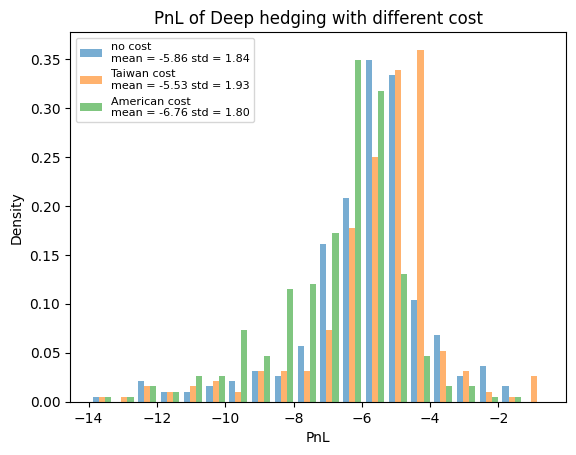

In [ ]:
bins=np.histogram(np.hstack((AAPL_DeepHedging_pnl_entropic_nocost.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_entropic_Tcost.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_DeepHedging_pnl_entropic_nocost.cpu().detach().numpy(),
          AAPL_DeepHedging_pnl_entropic_Tcost.cpu().detach().numpy() ,
          AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy()], bins, density = True, alpha = 0.6,

         label = [f'no cost\nmean = {AAPL_DeepHedging_pnl_entropic_nocost.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic_nocost.std():2.2f}',
                  f'Taiwan cost\nmean = {AAPL_DeepHedging_pnl_entropic_Tcost.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic_Tcost.std():2.2f}',
                  f'American cost\nmean = {AAPL_DeepHedging_pnl_entropic.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic.std():2.2f}'])

plt.title(f"PnL of Deep hedging with different cost")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()



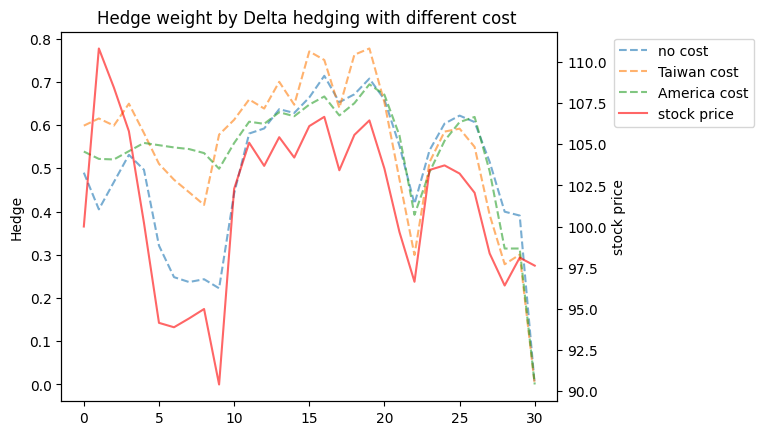

In [ ]:
data = AAPL_DeepHedging_hedgeweight_entropic_nocost.cpu().detach().numpy().T
data1 = AAPL_DeepHedging_hedgeweight_entropic_Tcost.cpu().detach().numpy().T
data2 = AAPL_DeepHedging_hedgeweight_entropic.cpu().detach().numpy().T

PATH = 23

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "no cost", linestyle = '--')
lns2 = ax1.plot(data1[PATH], alpha = 0.6, label = "Taiwan cost", linestyle = '--')
lns3 = ax1.plot(data2[PATH], alpha = 0.6, label = "America cost", linestyle = '--')

lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left', bbox_to_anchor=(1.1, 1))
plt.title(f'Hedge weight by Delta hedging with different cost ')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()

## Compare with BS delta hedging

### No cost

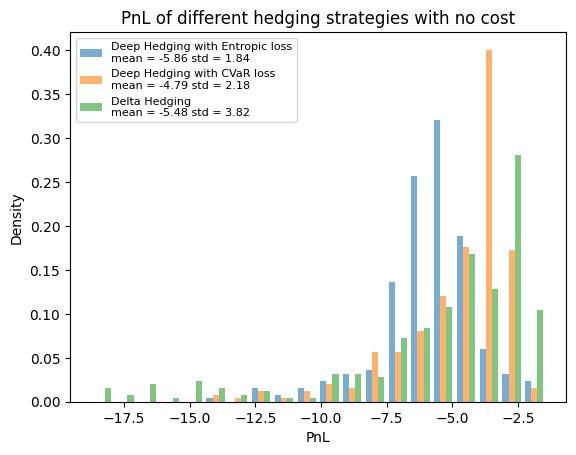

In [ ]:
bins=np.histogram(np.hstack((AAPL_DeepHedging_pnl_entropic_nocost.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_cvar_nocost.cpu().detach().numpy(),
                             AAPL_with_nocost.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_DeepHedging_pnl_entropic_nocost.cpu().detach().numpy(),
          AAPL_DeepHedging_pnl_cvar_nocost.cpu().detach().numpy() ,
          AAPL_with_nocost.cpu().detach().numpy()], bins, density = True, alpha = 0.6,

         label = [f'Deep Hedging with Entropic loss\nmean = {AAPL_DeepHedging_pnl_entropic_nocost.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic_nocost.std():2.2f}',
                  f'Deep Hedging with CVaR loss\nmean = {AAPL_DeepHedging_pnl_cvar_nocost.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar_nocost.std():2.2f}',
                  f'Delta Hedging\nmean = {AAPL_with_nocost.mean():2.2f} std = {AAPL_with_nocost.std():2.2f}'])

plt.title(f"PnL of different hedging strategies with no cost")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()



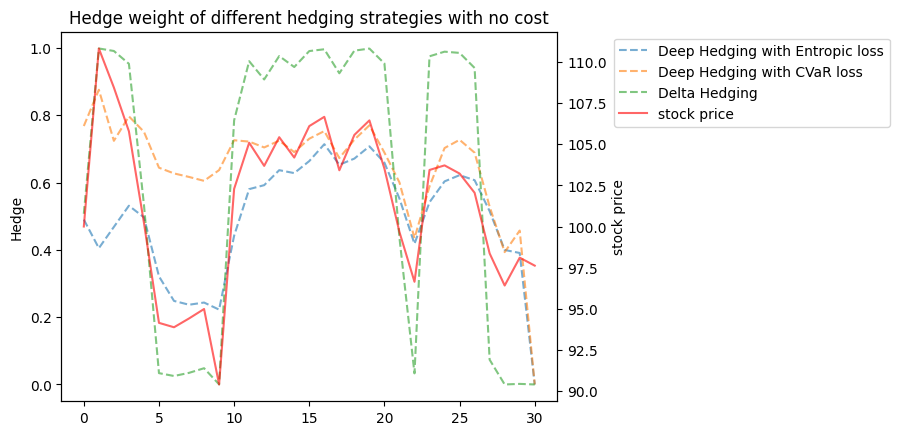

In [ ]:
data = AAPL_DeepHedging_hedgeweight_entropic_nocost.cpu().detach().numpy().T
data1 = AAPL_DeepHedging_hedgeweight_cvar_nocost.cpu().detach().numpy().T
data2 = hedge_weight_AAPL_with_nocost.cpu().detach().numpy().T

PATH = 23

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "Deep Hedging with Entropic loss", linestyle = '--')
lns2 = ax1.plot(data1[PATH], alpha = 0.6, label = "Deep Hedging with CVaR loss", linestyle = '--')
lns3 = ax1.plot(data2[PATH], alpha = 0.6, label = "Delta Hedging", linestyle = '--')

lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left', bbox_to_anchor=(1.1, 1))
plt.title(f'Hedge weight of different hedging strategies with no cost')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()

### T cost

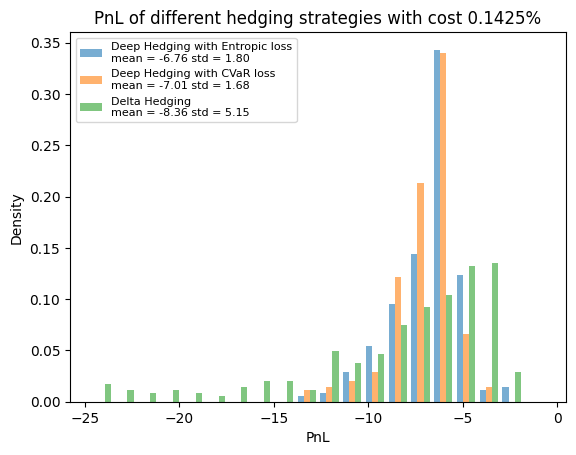

In [ ]:
bins=np.histogram(np.hstack((AAPL_DeepHedging_pnl_entropic_Tcost.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_cvar_Tcost.cpu().detach().numpy(),
                             AAPL_with_Americacost.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy(),
          AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy() ,
          AAPL_with_Americacost.cpu().detach().numpy()], bins, density = True, alpha = 0.6,

         label = [f'Deep Hedging with Entropic loss\nmean = {AAPL_DeepHedging_pnl_entropic.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic.std():2.2f}',
                  f'Deep Hedging with CVaR loss\nmean = {AAPL_DeepHedging_pnl_cvar.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar.std():2.2f}',
                  f'Delta Hedging\nmean = {AAPL_with_Americacost.mean():2.2f} std = {AAPL_with_Americacost.std():2.2f}'])

plt.title(f"PnL of different hedging strategies with cost 0.1425%")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()



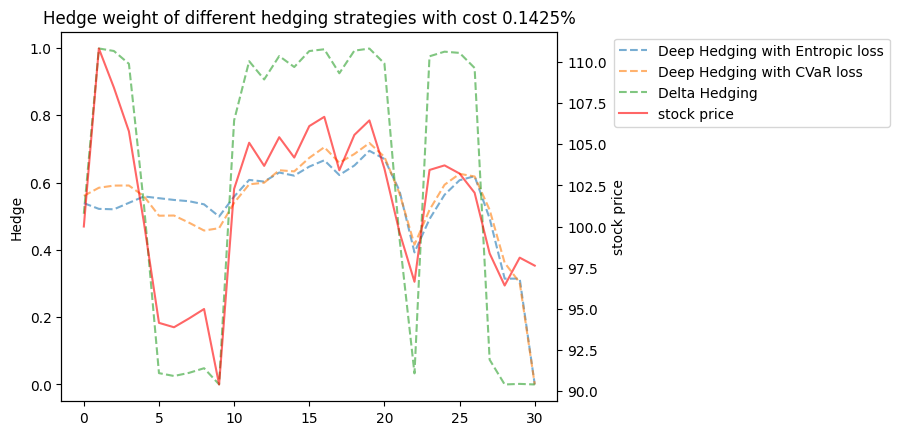

In [ ]:
data = AAPL_DeepHedging_hedgeweight_entropic.cpu().detach().numpy().T
data1 = AAPL_DeepHedging_hedgeweight_cvar.cpu().detach().numpy().T
data2 = hedge_weight_AAPL_with_Americacost.cpu().detach().numpy().T

PATH = 23

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "Deep Hedging with Entropic loss", linestyle = '--')
lns2 = ax1.plot(data1[PATH], alpha = 0.6, label = "Deep Hedging with CVaR loss", linestyle = '--')
lns3 = ax1.plot(data2[PATH], alpha = 0.6, label = "Delta Hedging", linestyle = '--')

lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left', bbox_to_anchor=(1.1, 1))
plt.title(f'Hedge weight of different hedging strategies with cost 0.1425%')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()

### American cost

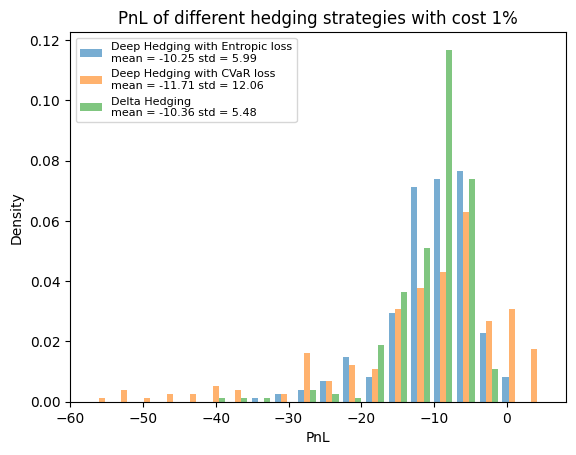

In [ ]:
bins=np.histogram(np.hstack((AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy(),
                             AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy(),
                             AAPL_with_Americacost.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_DeepHedging_pnl_entropic.cpu().detach().numpy(),
          AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy() ,
          AAPL_with_Americacost.cpu().detach().numpy()], bins, density = True, alpha = 0.6,

         label = [f'Deep Hedging with Entropic loss\nmean = {AAPL_DeepHedging_pnl_entropic.mean():2.2f} std = {AAPL_DeepHedging_pnl_entropic.std():2.2f}',
                  f'Deep Hedging with CVaR loss\nmean = {AAPL_DeepHedging_pnl_cvar.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar.std():2.2f}',
                  f'Delta Hedging\nmean = {AAPL_with_Americacost.mean():2.2f} std = {AAPL_with_Americacost.std():2.2f}'])

plt.title(f"PnL of different hedging strategies with cost 1%")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()



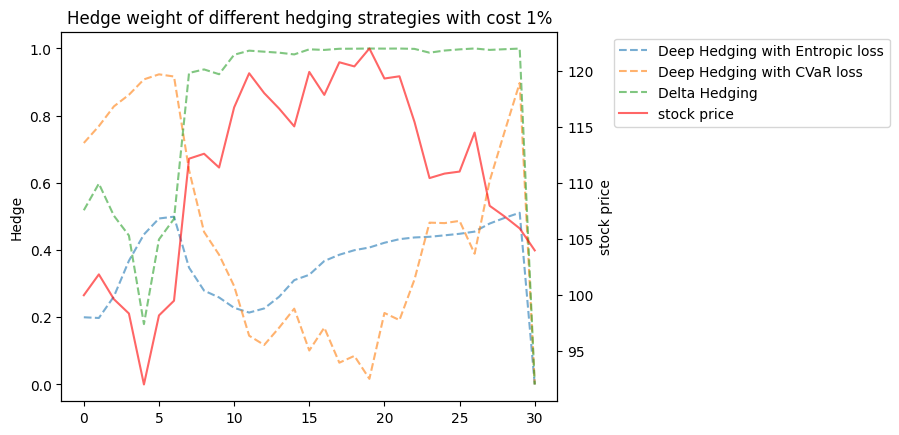

In [ ]:
data = AAPL_DeepHedging_hedgeweight_entropic.cpu().detach().numpy().T
data1 = AAPL_DeepHedging_hedgeweight_cvar.cpu().detach().numpy().T
data2 = hedge_weight_AAPL_with_Americacost.cpu().detach().numpy().T

PATH = 153

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "Deep Hedging with Entropic loss", linestyle = '--')
lns2 = ax1.plot(data1[PATH], alpha = 0.6, label = "Deep Hedging with CVaR loss", linestyle = '--')
lns3 = ax1.plot(data2[PATH], alpha = 0.6, label = "Delta Hedging", linestyle = '--')

lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left', bbox_to_anchor=(1.1, 1))
plt.title(f'Hedge weight of different hedging strategies with cost 1%')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.show()

### Others


In [ ]:
bins=np.histogram(np.hstack((AAPL_with_Americacost.cpu().detach().numpy(),AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy())), bins=20)[1] #get the bin edges

plt.hist([AAPL_with_Americacost.cpu().detach().numpy(), AAPL_DeepHedging_pnl_cvar.cpu().detach().numpy()], bins, density = True, alpha = 0.6,
         label = [f'Delta Hedging\nmean = {AAPL_with_Americacost.mean():2.2f} std = {AAPL_with_Americacost.std():2.2f}', f'Deep Hedging\nmean = {AAPL_DeepHedging_pnl_cvar.mean():2.2f} std = {AAPL_DeepHedging_pnl_cvar.std():2.2f}'])

plt.title(f"PnL of Deep hedging v.s. Black-Scholes model delta hedging")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend(fontsize = 8)
plt.show()

In [ ]:
data = AAPL_DeepHedging_hedgeweight_cvar.cpu().detach().numpy().T
PATH = 20

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(data[PATH], alpha = 0.6, label = "no cost", linestyle = '--')
lns4 = ax2.plot(Testing_data[:,PATH], alpha = 0.6, label = 'stock price',color = 'red')
plt.title(f'Hedge weight by Delta hedging with different cost under Black-Scholes model')
plt.xlabel('Time steps')
ax1.set_ylabel('Hedge')
ax2.set_ylabel('stock price')
plt.legend()
plt.show()

In [ ]:
deep_hedging_data = AAPL_DeepHedging_hedgeweight_cvar.cpu().detach().numpy().T
data = hedge_weight_AAPL_with_Americacost.cpu().detach().numpy().T
PATH = 37


plt.plot(deep_hedging_data[PATH], alpha = 0.6,label = 'Deep Hedging')
plt.plot(data[PATH], alpha = 0.6,label = 'BS Delta')


plt.title(f'{50} Paths generated by Black-Scholes model')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.legend()
plt.show()